<a href="https://colab.research.google.com/github/Leodntx/Cluster_RFM_Olist/blob/main/Cluster_RFM_Olist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto de Clusterização de Clientes da Olist (Segmentação RFM)

Este projeto tem como objetivo principal aplicar técnicas de Machine Learning Não Supervisionado para realizar a Segmentação de Clientes com base em seu comportamento de compra utilizando a metodologia RFM (Recência, Frequência e Valor Monetário) sobre o dataset de vendas da Olist

### Configuração Inicial e Carregamento dos Dados

In [1]:
# 1. Instalação e Importação das Bibliotecas Necessárias

import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Configuração de visualização
pd.set_option('display.max_columns', None)
sns.set_style("whitegrid")

print("Bibliotecas importadas com sucesso!")

Bibliotecas importadas com sucesso!


In [2]:
# 2. Carregamento dos Datasets

try:
    df_customers = pd.read_csv('olist_customers_dataset.csv')
    df_orders = pd.read_csv('olist_orders_dataset.csv')
    df_items = pd.read_csv('olist_order_items_dataset.csv')
    df_payments = pd.read_csv('olist_order_payments_dataset.csv')

    print("\nDatasets carregados com sucesso!")

except FileNotFoundError:
    print("\nERRO: Certifique-se de que todos os arquivos CSV estão carregados no seu ambiente Colab!")


Datasets carregados com sucesso!


### Passo 1: Limpeza e Combinação dos Dados (Feature Engineering RFM)

In [3]:
# 1. Tratar e Filtrar Pedidos
# Converte as colunas de data para o formato datetime
df_orders['order_purchase_timestamp'] = pd.to_datetime(df_orders['order_purchase_timestamp'])

# Filtra apenas pedidos entregues para garantir transações concluídas
df_orders_delivered = df_orders[df_orders['order_status'] == 'delivered']

# 2. Calcular o Valor Total do Pedido (Preço dos Itens + Frete)
# Une Itens e Pagamentos (o valor do pagamento é geralmente o valor total)
df_payments_total = df_payments.groupby('order_id')['payment_value'].sum().reset_index()
df_payments_total.rename(columns={'payment_value': 'total_payment_value'}, inplace=True)


# 3. Merge dos Datasets
# A. Une Pedidos com Pagamentos
df_merge = pd.merge(df_orders_delivered, df_payments_total, on='order_id', how='inner')

# B. Une com Clientes Únicos
df_final = pd.merge(df_merge, df_customers[['customer_id', 'customer_unique_id']],
                     on='customer_id', how='left')

# Excluir pedidos com valor de pagamento zero ou negativo (Outliers)
df_final = df_final[df_final['total_payment_value'] > 0]

print("\nCombinação de dados concluída.")
print("Número total de transações válidas:", len(df_final))


Combinação de dados concluída.
Número total de transações válidas: 96477


### Passo 2: Cálculo das Métricas RFM (Recência, Frequência, Monetário)

In [4]:
# 1. Definir a Data de Referência
# Usamos a data da última compra + 1 dia como "hoje"
NOW = df_final['order_purchase_timestamp'].max() + pd.Timedelta(days=1)

# 2. Calcular RFM
rfm_df = df_final.groupby('customer_unique_id').agg(
    # Recência (R): Diferença entre a data de referência e a data da última compra (em dias)
    Recency=('order_purchase_timestamp', lambda x: (NOW - x.max()).days),

    # Frequência (F): Número total de pedidos
    Frequency=('order_id', 'nunique'),

    # Valor Monetário (M): Soma do valor total pago
    Monetary=('total_payment_value', 'sum')
).reset_index()

print("\nDataFrame RFM (amostra):")
print(rfm_df.head())


DataFrame RFM (amostra):
                 customer_unique_id  Recency  Frequency  Monetary
0  0000366f3b9a7992bf8c76cfdf3221e2      112          1    141.90
1  0000b849f77a49e4a4ce2b2a4ca5be3f      115          1     27.19
2  0000f46a3911fa3c0805444483337064      537          1     86.22
3  0000f6ccb0745a6a4b88665a16c9f078      321          1     43.62
4  0004aac84e0df4da2b147fca70cf8255      288          1    196.89


### Passo 3: Preparação dos Dados para o K-Means

In [5]:
# 1. Análise e Remoção de Outliers (opcional, mas recomendado para RFM)
# A clusterização K-Means é sensível a outliers, especialmente no valor Monetário.
# Vamos usar o Log para mitigar a assimetria (skewness).

# 2. Aplicação da Transformação Logarítmica
# Adicionar uma pequena constante (epsilon) antes do log para evitar log(0)
epsilon = 1e-6
rfm_log = rfm_df[['Recency', 'Frequency', 'Monetary']].apply(lambda x: np.log(x + epsilon))

# 3. Escalonamento dos Dados (StandardScaler)
# O scaler garante que todas as variáveis tenham peso igual na clusterização
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)

rfm_scaled_df = pd.DataFrame(rfm_scaled, columns=['R_scaled', 'F_scaled', 'M_scaled'])

print("\nDataFrame RFM Escalado (amostra):")
print(rfm_scaled_df.head())


DataFrame RFM Escalado (amostra):
   R_scaled  F_scaled  M_scaled
0 -0.459456 -0.172192  0.291362
1 -0.431651 -0.172192 -1.732576
2  1.189395 -0.172192 -0.318928
3  0.648133 -0.172192 -1.153587
4  0.534022 -0.172192  0.692559


### Passo 4: Determinação do Número Ótimo de Clusters (Método do Cotovelo)

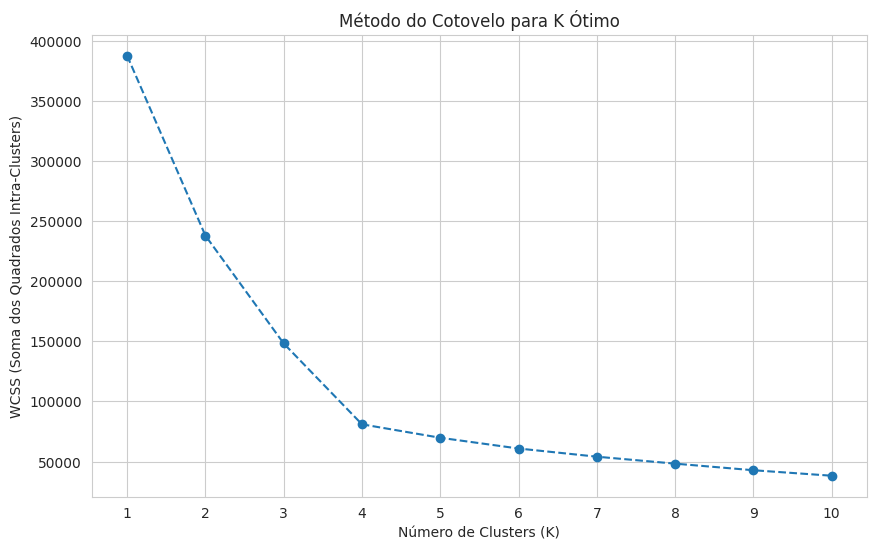

In [11]:
# 1. Cálculo da Soma dos Quadrados das Distâncias (WCSS)
wcss = []
K_range = range(1, 11) # Testar de 1 a 10 clusters

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled_df)
    wcss.append(kmeans.inertia_)

# 2. Visualização do Método do Cotovelo
plt.figure(figsize=(10, 6))
plt.plot(K_range, wcss, marker='o', linestyle='--')
plt.title('Método do Cotovelo para K Ótimo')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('WCSS (Soma dos Quadrados Intra-Clusters)')
plt.xticks(K_range)
plt.show()

# Baseado no gráfico, você deve escolher o ponto onde o declínio da curva começa a se estabilizar
# Ex: Se o "cotovelo" estiver em K=4 ou K=5, escolha esse valor.

### Passo 5: Treinamento do Modelo e Análise dos Clusters


Perfis de Clientes por Cluster (Valores Médios RFM):
   Cluster  Count  Recency_Mean  Frequency_Mean  Monetary_Mean
0        0  42201        286.53            1.00          67.89
1        1  32604        271.64            1.00         293.95
2        2   2801        220.29            2.11         308.59
3        3  15751         41.12            1.00         133.90


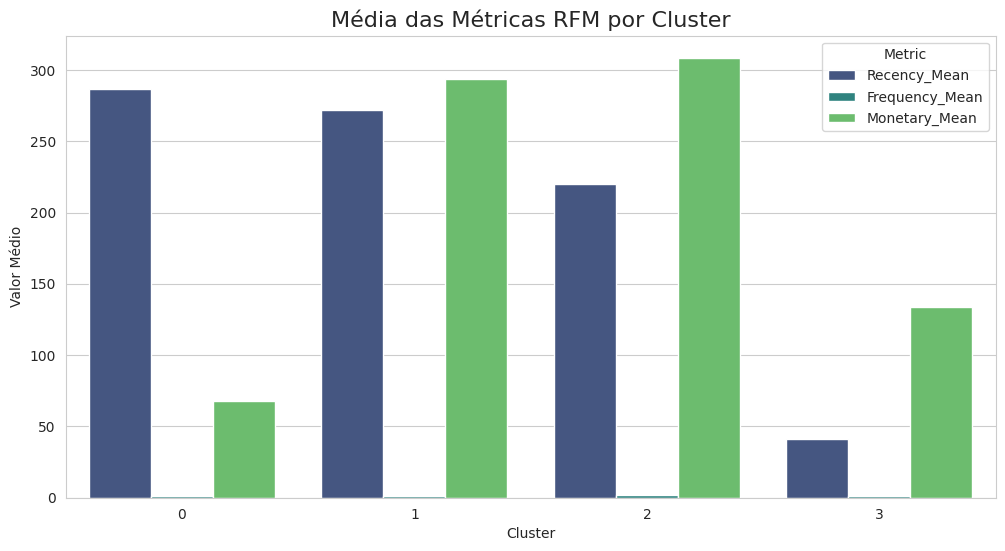

In [10]:
# *ATENÇÃO: Altere o valor de n_clusters para o K que você escolheu no Passo 4*
K_OPTIMO = 4

# 1. Treinamento do Modelo K-Means
kmeans_final = KMeans(n_clusters=K_OPTIMO, random_state=42, n_init=10)
rfm_scaled_df['Cluster'] = kmeans_final.fit_predict(rfm_scaled_df[['R_scaled', 'F_scaled', 'M_scaled']])

# 2. Anexar os rótulos de cluster ao DataFrame RFM original
rfm_df['Cluster'] = rfm_scaled_df['Cluster']

# 3. Análise do Perfil dos Clusters (Valores não escalados)
cluster_profiles = rfm_df.groupby('Cluster').agg(
    Count=('customer_unique_id', 'count'),
    Recency_Mean=('Recency', 'mean'),
    Frequency_Mean=('Frequency', 'mean'),
    Monetary_Mean=('Monetary', 'mean')
).reset_index()

# Ordenar Recência de forma decrescente para facilitar a interpretação
cluster_profiles.sort_values(by='Recency_Mean', ascending=False, inplace=True)

print("\nPerfis de Clientes por Cluster (Valores Médios RFM):")
print(cluster_profiles.round(2))

# 4. Visualização dos Perfis
cluster_profiles_melted = cluster_profiles.drop(columns=['Count']).melt(
    id_vars='Cluster', var_name='Metric', value_name='Value'
)

plt.figure(figsize=(12, 6))
sns.barplot(x='Cluster', y='Value', hue='Metric', data=cluster_profiles_melted, palette='viridis')
plt.title('Média das Métricas RFM por Cluster', fontsize=16)
plt.ylabel('Valor Médio')
plt.xlabel('Cluster')
plt.show()

### Passo 6: Conclusão e Recomendações de Negócio

Este projeto aplicou o modelo de clusterização K-Means na base de clientes RFM da Olist para segmentar a base de consumidores com base em seu comportamento de compra. O método do Cotovelo indicou $K=4$ como o número ideal de grupos, revelando perfis de clientes distintos e acionáveis para o negócio.

### Segmentos Identificados e Características

A análise do perfil médio de Recência (R), Frequência (F) e Valor Monetário (M) para cada grupo levou à seguinte nomenclatura:

| Cluster | Nome do Segmento | Recência Média | Frequência Média | Valor Monetário Médio | Tamanho |
| :---: | :--- | :---: | :---: | :---: | :---: |
| **2** | Campeões (Fiéis e Mais Lucrativos) | 220 dias | 2.11 | R\$ 308,59 | 2.801 clientes |
| **3** | Novos Clientes (Potenciais) | 41 dias | 1.00 | R\$ 133,90 | 15.751 clientes |
| **1** | Alto Valor em Risco (Quase Perdidos) | 271 dias | 1.00 | R\$ 293,95 | 32.604 clientes |
| **0** | Adormecidos (Baixo Retorno) | 286 dias | 1.00 | R\$ 67,89 | 42.201 clientes |

### Recomendações Estratégicas para a Olist

Os insights extraídos da clusterização permitem que a Olist otimize o investimento em marketing, focando em ações que maximizem a retenção e a receita de cada segmento:

1. Foco na Fidelização e Receita (Cluster 2 - Campeões)
Estratégia: Priorizar a retenção e o aumento do Ticket Médio.

Ações Sugeridas:

*   Implementar um Programa de Lealdade VIP (ex: descontos  progressivos ou frete grátis exclusivo) para recompensar a alta frequência.
*   Enviar comunicações personalizadas com lançamentos de produtos premium (upselling) nas categorias que mais compram.

2. Foco na Conversão (Cluster 3 - Novos Clientes)
Estratégia: Transformar a primeira compra em um hábito.

Ações Sugeridas:

*   Desenvolver uma série de e-mails de onboarding nos primeiros 60  dias, oferecendo um incentivo forte (ex: 15% de desconto) para a segunda compra (aumentar a Frequência).
*   Oferecer sugestões de produtos complementares com base no primeiro item adquirido.

3. Foco na Reativação (Cluster 1 - Alto Valor em Risco)
Estratégia: Resgatar clientes de alto potencial de receita antes que se tornem "perdidos".

Ações Sugeridas:

* Campanha de reengajamento imediato com ofertas de alto valor percebido (ex: "Sentimos sua falta: R$ 50 OFF na próxima compra").

* Conduzir uma pesquisa de satisfação (survey) rápida para identificar o motivo do abandono (ex: problema de frete, qualidade do produto).

4. Foco na Otimização de Custos (Cluster 0 - Adormecidos)
Estratégia: Manter a visibilidade com baixo investimento.

Ações Sugeridas:

* Utilizar canais de baixo custo, como e-mail marketing automático e retargeting em mídias sociais, com o objetivo de reativar uma pequena parcela sem gastar muito recurso.